In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import nibabel as nib
from PIL import Image
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU

2023-01-10 15:54:05.078763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 15:54:07.204819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-10 15:54:07.204978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-10 15:54:07.204986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
def LoadData2(p1,p2):
    data_ = nib.load(p1).get_fdata()
    data = np.transpose(data_,(2,0,1))
    label_ = nib.load(p2).get_fdata()
    label = np.transpose(label_,(2,0,1))
    
    return data,label

In [ ]:
fns1 = sorted(glob.glob('Task101_SCGM/imagesTr/*'))
fns2 = sorted(glob.glob('Task101_SCGM/labelsTr/*'))
Ad_Data,Ad_GT=LoadData2(fns1[0],fns2[0])
for i in range(1,len(fns1)):
    im1,im2=LoadData2(fns1[i],fns2[i])
    Ad_Data = np.concatenate((Ad_Data, im1), axis=0)  
    Ad_GT = np.concatenate((Ad_GT, im2), axis=0) 

In [ ]:
import joblib as jlb
jlb.dump((Ad_Data,Ad_GT),"Ad_Data_GT.data")

In [ ]:
import joblib as jlb
Ad_Data,Ad_GT=jlb.load("Ad_Data_GT.data")

In [ ]:
# Data2 = sorted(glob.glob('Task101_SCGM/imagesTr/*'))
# GT2 = sorted(glob.glob('Task101_SCGM/labelsTr/*'))
# for i,j in zip(Data2,GT2):
#     print(i,j)

In [ ]:
# *****************

In [2]:
n_class = 5

def split_filename(filepath):
    path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    base, ext = os.path.splitext(filename)
    if ext == '.gz':
        base, ext2 = os.path.splitext(base)
        ext = ext2 + ext
    return path, base, ext

def ProcessImage(path_file,mode='None',norm=True):
    dataset = []
    try:
        fns = sorted(glob.glob(path_file))
        for fn in fns:
            _, base, ext = split_filename(fn)
            img = nib.load(fn).get_data().astype(np.float32).squeeze()
            if img.ndim != 3:
                print(f'Only 3D data supported. File {base}{ext} has dimension {img.ndim}. Skipping.')
                continue
            
            if mode =='mask':
                for i in range(img.shape[2]):
                    r_img =  img[:,:,i]
                    dataset.append(r_img)
            
            else:
                for i in range(img.shape[2]):
                    I = Image.fromarray(img[:,:,i], mode='F')

                    oldmin = np.min(I)
                    oldmax = np.max(I)
                    oldrange = oldmax-oldmin

                    newmin = 0
                    newmax = 255
                    newrange = newmax-newmin
                    scale =(I-oldmin)/oldrange
                    if norm:
                        normal_img = ((newrange*scale) + newmin)/255.
                    else:
                        normal_img = ((newrange*scale) + newmin)

                    dataset.append(normal_img)


        return np.array(dataset)
    except Exception as e:
        print(e)
        return 1


In [3]:
def LoadData():
#     path_to_data = 'Task101_SCGM/imagesTr/*.nii*'
#     path_to_mask = 'Task101_SCGM/labelsTr/*.nii*'
    path_to_data = 'new_c/*.nii*'
    path_to_mask = 'new_s/*.nii*'
    unmask = ProcessImage(path_to_data,mode='unmask',norm=False)
    mask = ProcessImage(path_to_mask,mode='mask')
    return unmask,mask


In [4]:
def downsample(filters, size, shape, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer=initializer))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())

    return result

def upsample(filters, size, shape, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,padding='same',
                                    kernel_initializer=initializer))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.2))

    result.add(tf.keras.layers.ReLU())

    return result

def buildUNet():
    inputs = tf.keras.layers.Input(shape=[512,512,1])

    down_stack = [
        downsample(32, 3, (None, 512, 512,1), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(64, 3, (None, 256, 256, 32)), # (bs, 64, 64, 128)
        downsample(64, 3, (None, 128, 128, 64)), # (bs, 32, 32, 256)
        downsample(64, 3, (None, 64, 64, 64)),
        downsample(64, 3, (None, 32, 32, 64)), # (bs, 16, 16, 512)
        downsample(64, 3, (None, 16, 16, 64)), # (bs, 8, 8, 512)
        downsample(64, 3, (None, 8, 8, 64)), # (bs, 4, 4, 512)
        downsample(64, 3, (None, 4, 4, 64)), # (bs, 2, 2, 512)
        downsample(64, 3, (None, 2, 2, 64)), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(64, 3, (None, 1, 1, 64), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(64, 3, (None, 2, 2, 128), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(64, 3, (None, 4, 4, 128), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(64, 3, (None, 8, 8, 128)), # (bs, 16, 16, 1024)
        upsample(64, 3, (None, 16, 16, 128)), # (bs, 32, 32, 512)
        upsample(32, 3, (None, 32, 32, 128)), # (bs, 64, 64, 256)
        upsample(32, 3, (None, 64, 64, 96)), # (bs, 128, 128, 128)
        upsample(32, 3, (None, 128, 128, 96)),
    ]


    prev_last = tf.keras.layers.Conv2DTranspose(16, 3,strides=2,padding='same')
    last = tf.keras.layers.Conv2DTranspose(n_class, 3,padding='same',activation='softmax') # (bs, 256, 256, n_class)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = prev_last(x)
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [5]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
def Encode_label(mask):
    labelencoder = LabelEncoder()
    n, h, w = mask.shape
    mask_reshape = mask.reshape(-1,1)
    mask_reshape_encoded = labelencoder.fit_transform(mask_reshape)
    return_mask_shape = mask_reshape_encoded.reshape((n,h,w))
#     class_weights = class_weight.compute_class_weight('balanced',np.unique(mask_reshape_encoded),mask_reshape_encoded)

    return return_mask_shape#,class_weights

def Plot_ACC_LOSS(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss,'y',label='Traning loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title('Traning and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.plot(epochs,acc,'y',label='Traning Accuracy')
    plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
    plt.title('Traning and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [6]:
unmask,mask = LoadData()

/tmp/ipykernel_2263605/3720160665.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(fn).get_data().astype(np.float32).squeeze()


In [7]:
# encoded_mask, class_weights = Encode_label(mask)
encoded_mask = Encode_label(mask)

/home/lkarimi/venv-jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
unmask = np.expand_dims(unmask,axis=3)
mask = np.expand_dims(encoded_mask,axis=3)

In [9]:
x_train,x_test,y_train,y_test = train_test_split(unmask,mask,test_size=0.2,random_state=0)

In [10]:

train_mask_cat = to_categorical(y_train,num_classes=n_class)


In [11]:
y_train_cat = train_mask_cat.reshape((y_train.shape[0],y_train.shape[1],y_train.shape[2],n_class))

test_mask_cat = to_categorical(y_test,num_classes=n_class)
y_test_cat = test_mask_cat.reshape((y_test.shape[0],y_test.shape[1],y_test.shape[2],n_class))


# print('class weight...',class_weights)

In [12]:
class_weights2 = {0: 0.20741071, 1:44.4471225, 2:48.09415971, 3:11.03603361, 4:22.34902203}

""" img_height = x_train.shape[1]
img_weight = x_train.shape[2]
img_channels = x_train.shape[3] """

model = buildUNet()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


2023-01-09 10:21:06.515192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 10:21:07.038441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38172 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 128, 128, 64  18752       ['sequential[0][0]']             
                                )                                                             

In [13]:

history = model.fit(x_train,y_train_cat,
                    batch_size=16,
                    verbose=1,
                    epochs=50,
                    validation_data=(x_test,y_test_cat),
                    #class_weight=class_weights,
                    shuffle=False)

Epoch 1/50


2023-01-09 10:21:18.151369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_9/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-09 10:21:19.522650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-01-09 10:21:20.023726: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-09 10:21:20.783810: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x555576f00b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-09 10:21:20.783858: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-01-09 10:21:20.788656: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash repro

97/97 [==============================] - 21s 97ms/step - loss: 0.2857 - accuracy: 0.9412 - val_loss: 0.1872 - val_accuracy: 0.9728
Epoch 2/50
97/97 [==============================] - 7s 68ms/step - loss: 0.0706 - accuracy: 0.9762 - val_loss: 0.1462 - val_accuracy: 0.9732
Epoch 3/50
97/97 [==============================] - 7s 68ms/step - loss: 0.0611 - accuracy: 0.9774 - val_loss: 0.0942 - val_accuracy: 0.9743
Epoch 4/50
97/97 [==============================] - 7s 68ms/step - loss: 0.0553 - accuracy: 0.9785 - val_loss: 0.0570 - val_accuracy: 0.9780
Epoch 5/50
97/97 [==============================] - 7s 69ms/step - loss: 0.0515 - accuracy: 0.9796 - val_loss: 0.0543 - val_accuracy: 0.9798
Epoch 6/50
97/97 [==============================] - 7s 68ms/step - loss: 0.0484 - accuracy: 0.9807 - val_loss: 0.0644 - val_accuracy: 0.9778
Epoch 7/50
97/97 [==============================] - 7s 68ms/step - loss: 0.0450 - accuracy: 0.9822 - val_loss: 0.0583 - val_accuracy: 0.9796
Epoch 8/50
97/97 [=====

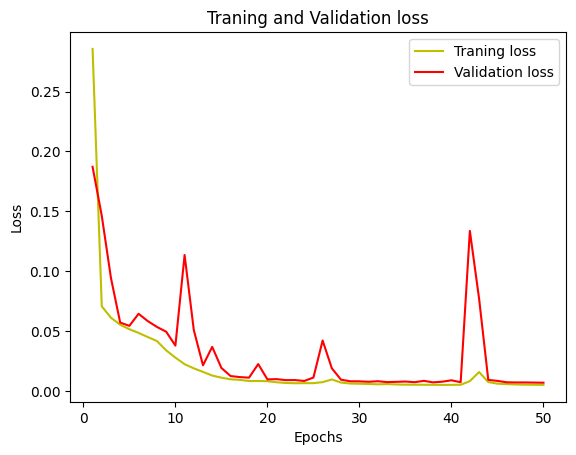

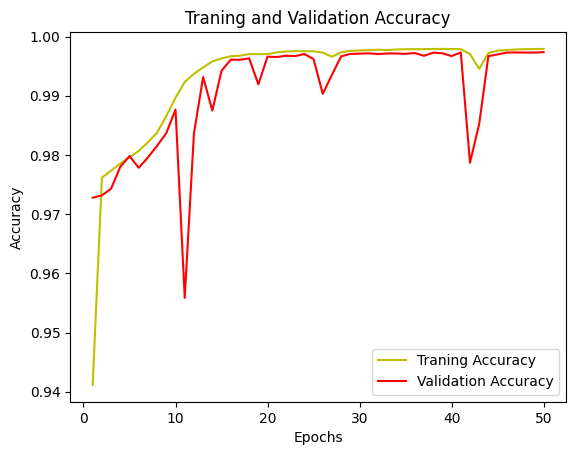

13/13 [==============================] - 1s 47ms/step - loss: 0.0068 - accuracy: 0.9974
Accuracy is : 99.73657131195068 %
13/13 [==============================] - 1s 31ms/step
Mean IoU is : 0.9204012


In [14]:
Plot_ACC_LOSS(history)
model.save("seg-5class.hdf5")

_,acc = model.evaluate(x_test,y_test_cat)
print("Accuracy is :",(acc * 100.0),"%")


model.load_weights("seg-5class.hdf5")

y_pred = model.predict(x_test)
y_pred_arg = np.argmax(y_pred,axis=3)

IoU = MeanIoU(num_classes=n_class)
IoU.update_state(y_test[:,:,:,0],y_pred_arg)

print("Mean IoU is :",IoU.result().numpy())

In [15]:
y_pred.shape

(386, 512, 512, 5)

In [16]:
y_pred_arg.shape

(386, 512, 512)

1/1 [==============================] - 0s 22ms/step


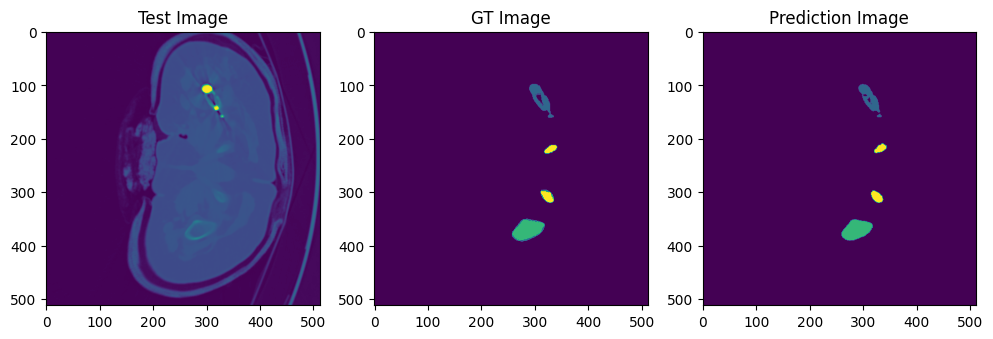

In [27]:
n_test_img = np.random.randint(0,len(x_test)-1)
test_img = x_test[n_test_img]
GT = y_test[n_test_img]
test_img_input = np.expand_dims(test_img,axis=0)
prediction = (model.predict(test_img_input))
pred_img = np.argmax(prediction,axis=3)[0]

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('GT Image')
plt.imshow(GT)
plt.subplot(133)
plt.title('Prediction Image')
plt.imshow(pred_img)
plt.show()